<span style="font-family:Papyrus; font-size:3em;" >Estimating Parameter Confidence Intervals With Bootstrapping</span>

This notebook demonstrates the calculations required to do confidence interval constructions.
1. Construct a good model. This means checking that we get good $R^2$ values (or other model quality metrics) for each fold in a cross validation.
1. Compute residuals for the good model.
1. Construct a collection of parameter estimates. That is, for many repetitions
   1. Construct new observations (by using randomly selected residuals)
   1. Estimate parameter values
1. Construct the confidence interval

# Programming Preliminaries

In [1]:
IS_COLAB = False
#
if IS_COLAB:
  !pip install matplotlib
  !pip install numpy
  !pip install tellurium
  !pip install SBstoat
#    
# Constants for standalone notebook
if not IS_COLAB:
    CODE_DIRS = ["/home/ubuntu/advancing-biomedical-models/common"]
    CODE_DIRS.append("/home/ubuntu/SBstoat")
    DATA_DIR = "/home/ubuntu/advancing-biomedical-models/lecture_12"
else:
    from google.colab import drive
    drive.mount('/content/drive')
    CODE_DIRS = ["/content/drive/MyDrive/Winter 2021/common"]
    DATA_DIR = "/content/drive/MyDrive/Modeling_Class/Lecture Notes/12_lecture"
import sys
for path in CODE_DIRS:
    sys.path.insert(0, path)
# Other constants
TIME = "time"

In [2]:
%matplotlib inline
import numpy as np
import lmfit   # Fitting lib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import tellurium as te
from SBstoat.modelFitter import ModelFitter
from SBstoat.observationSynthesizer import ObservationSynthesizerRandomizedResiduals, ObservationSynthesizerRandomErrors
from SBstoat.namedTimeseries import NamedTimeseries

# Model and Data

In [4]:
# Model used in this example
MODEL = """
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0.1
     k2 = 0.2
"""
PARAMETERS_TO_FIT = ["k1", "k2"]

In [5]:
# Globals
NUM_POINT = 30
SIM_TIME= 30
NOISE_STD = 0.3

In [6]:
rr = te.loada(MODEL)
fittedData = rr.simulate(0, SIM_TIME, NUM_POINT)
fittedTS = NamedTimeseries(namedArray=fittedData)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=NOISE_STD)
OBS_TS = synthesizer.calculate()
OBS_TS

                  A         B         C
time                                   
0.000000   5.273324 -0.866487  0.140481
1.034483   4.658704  0.451808  0.028226
2.068966   3.934367  0.880723  0.215681
3.103448   3.513273  1.365989  0.865850
4.137931   3.760485  1.532430  0.231799
5.172414   3.409644  1.419906  0.738220
6.206897   2.704730  1.765392  1.321748
7.241379   1.917897  1.024720  0.951331
8.275862   2.729089  1.328110  1.554919
9.310345   1.916003  1.004007  1.831669
10.344828  1.640621  1.266796  2.185251
11.379310  1.231828  0.887684  1.920616
12.413793  1.278424  0.671575  2.752982
13.448276  1.338452  0.982233  2.704019
14.482759  1.229860  0.907135  2.862819
15.517241  0.686440  0.401615  3.205526
16.551724  1.556460  1.018120  3.367376
17.586207  0.380049  0.678177  3.812578
18.620690  0.620751  0.410490  3.547358
19.655172  1.024537  0.571086  3.744843
20.689655  0.666914  0.627168  3.891986
21.724138  0.410299  0.169427  4.357694
22.758621  0.263998  1.033851  3.812689


In [7]:
def plotData(observedTS):
    """
    Creates a scatter plot of the observed data.
    
    Parameters
    ----------
    observedTS: NamedTimeseries
    
    Returns
    -------
    
    """
    figure, ax = plt.subplots(1)
    for column in observedTS.colnames:
        _ = ax.scatter(observedTS[TIME], observedTS[column])
    _ = plt.legend(observedTS.colnames)
    return figure
        
# Tests
figure = plotData(OBS_TS)
assert(isinstance(figure, matplotlib.figure.Figure))
_ = figure.clear()

<Figure size 432x288 with 0 Axes>

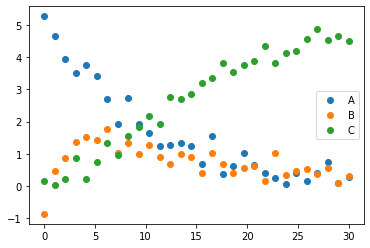

In [8]:
_ = plotData(OBS_TS)

# Bootstrapping Workflow

## Construct a good model.

First, we need to estimate the parameter values to use in our model. To this end, we do a fit on the full set of data.

In [9]:
FITTER = ModelFitter(MODEL, OBS_TS, parametersToFit=["k1", "k2"])
FITTER.fitModel()
FITTED_TS = FITTER.fittedTS
PARAMETER_ESTIMATES = FITTER.params
PARAMETER_ESTIMATES

name,value,initial value,min,max,vary
k1,0.10383942,0.07636478615333342,0.00000000,10.0000000,True
k2,0.20035088,0.2847890343481829,0.00000000,10.0000000,True


In [10]:
print(FITTER.reportFit())

[[Variables]]
    k1:  0.10383942127357215
    k2:  0.2003508781364749
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 90
    # variables        = 2
    chi-square         = 6.77994133
    reduced chi-square = 0.07704479
    Akaike info crit   = -228.725710
    Bayesian info crit = -223.726091
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k2) = -0.403


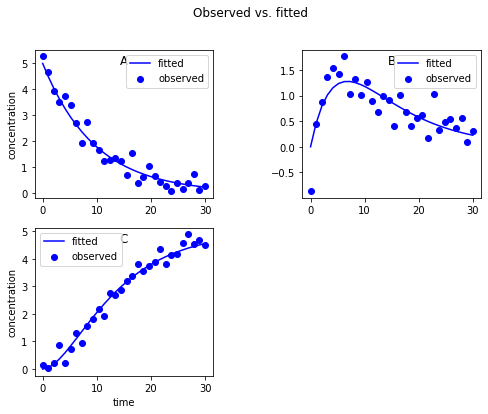

In [32]:
FITTER.plotFitAll()

**Question**
1. What are the parameter estimates if the NOSE_STD is 0.8?

## Compute the Residuals
Residuals need to be calculated by chemical species since they may be in very different units.

In [33]:
# Note that the residuals for the chemical species differ. Compare the residuals for A (1st col) with
# the residuals for C (3rd col)
columns = FITTED_TS.colnames
RESIDUALS_TS = OBS_TS.copy()  # Create the shape of the residuals
RESIDUALS_TS[columns] -= FITTED_TS[columns]
RESIDUALS_TS

                  A         B         C
time                                   
0.000000   0.273324 -0.866487  0.140481
1.034483   0.167963 -0.007289 -0.021935
2.068966  -0.098984  0.095228  0.034528
3.103448  -0.109275  0.357193  0.497195
4.137931   0.506900  0.379853 -0.362039
5.172414   0.487442  0.184339 -0.104011
6.206897   0.080160  0.492799  0.218912
7.241379  -0.439357 -0.250641 -0.416054
8.275862   0.611926  0.075043 -0.074852
9.310345   0.014476 -0.208892 -0.053906
10.344828 -0.067232  0.106346  0.053554
11.379310 -0.302077 -0.212354 -0.445441
12.413793 -0.099250 -0.363387  0.165618
13.448276  0.101096  0.014511 -0.090903
14.482759  0.118531  0.006949 -0.125666
15.517241 -0.311698 -0.432105  0.037384
16.551724  0.659984  0.248817  0.033156
17.586207 -0.425120 -0.029433  0.325356
18.620690 -0.102410 -0.238592 -0.080400
19.655172  0.375031 -0.022893 -0.011673
20.689655  0.083561  0.084740  0.017767
21.724138 -0.113639 -0.325026  0.376084
22.758621 -0.206575  0.583847 -0.266734


In [34]:
# The standard deviation of the residuals should be approximately the same as the standard deviation
# of the random noise we injected in the construction of the observations.
np.std(RESIDUALS_TS.flatten())

0.27355893724745634

A validation of our codes and workflow is that the standard deviation of the residuals is close to the standard deviation of the noise used in the observational data.

## Construct a Collection of Parameter Estimates

### Step 3a: Construct Synthetic Observations
We define a function that constructs a set of observations from residuals and a model.

In [47]:
synthesizer = ObservationSynthesizerRandomizedResiduals(fittedTS=FITTED_TS, 
                                                        observedTS=OBS_TS)

In [49]:
synthesizer.calculate()

                  A         B         C
time                                   
0.000000   5.085411  0.184339  0.325356
1.034483   4.609272  0.377117  0.215780
2.068966   3.966120  0.870229  0.218537
3.103448   3.310850  1.079342  0.422210
4.137931   3.272698  1.237311  0.919194
5.172414   3.195526  1.819414  0.788326
6.206897   2.681483  1.471743  1.600030
7.241379   2.815843  1.066469  1.297204
8.275862   2.492195  1.632919  1.795389
9.310345   1.958438  1.283445  1.920102
10.344828  1.268496  1.131018  2.051297
11.379310  1.807229  1.106987  2.275154
12.413793  1.237012  0.784320  2.533458
13.448276  1.612387  1.460521  2.783249
14.482759  1.002054  0.687832  2.913633
15.517241  0.791563  0.826431  3.243995
16.551724  1.169800  0.762014  2.972182
17.586207  0.737937  0.275505  3.220487
18.620690  0.737637  1.141880  3.793376
19.655172  0.550256  0.586690  3.975428
20.689655  0.158233  0.291787  3.820314
21.724138  0.456705  0.874306  3.906758
22.758621  0.977473  0.520549  3.953758


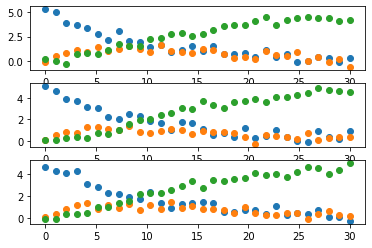

In [52]:
size = 3
fig, axes = plt.subplots(size)
for idx in range(size):
    ax = axes[idx]
    residualsTS = synthesizer.calculate()
    xvalues = residualsTS["time"]
    for col in residualsTS.colnames:
        ax.scatter(xvalues, residualsTS[col])

### Repeatedly estimate parameter values

In [53]:
def estimateParameters(model, observedTS, parametersToFit, numIteration=10):
    estimateDct = {p: [] for p in parametersToFit}
    # Get the initial estimates
    fitter = ModelFitter(model, observedTS, parametersToFit=parametersToFit)
    fitter.fitModel()
    initialParams = fitter.params
    # Create the observation synthesizer
    synthesizer = ObservationSynthesizerRandomizedResiduals(fittedTS=fitter.fittedTS, observedTS=observedTS)
    # Iterative calculate parameters
    for _ in range(numIteration):
        newObservedTS = synthesizer.calculate()
        newFitter = ModelFitter(model, newObservedTS, parametersToFit=parametersToFit)
        newFitter.fitModel(params=initialParams)
        [estimateDct[p].append(newFitter.params.valuesdict()[p]) for p in parametersToFit]
    return estimateDct

# Tests
numIteration = 5
estimateDct = estimateParameters(MODEL, OBS_TS, PARAMETERS_TO_FIT, numIteration=numIteration)
assert(len(estimateDct[PARAMETERS_TO_FIT[0]]) == len(estimateDct[PARAMETERS_TO_FIT[1]]))
assert(len(estimateDct[PARAMETERS_TO_FIT[0]]) == numIteration)

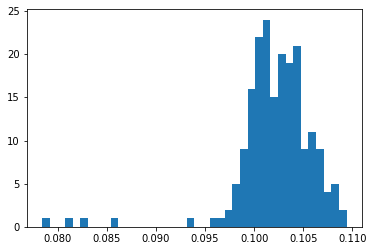

In [81]:
_ = plt.hist(ESTIMATE_DCT["k1"],bins=40)

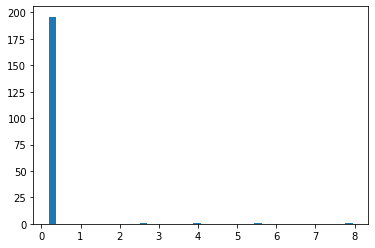

In [82]:
_ = plt.hist(ESTIMATE_DCT["k2"],bins=40)

**Questions**
1. How do the quality of the parameter estimates change with the number of simulation points? With the simulation time?

## Compute Confidence Intervals

In [18]:
np.quantile(range(10), [.10, .90])

array([0.9, 8.1])

**Question**
1. Calculate 95% confidence intervals for the parameters.
   1. How many iterations should you use?

### Solution

In [19]:
# Solution
for parameter in estimateDct.keys():
    quantile = np.quantile(estimateDct[parameter], [0.025, 0.975])
    print("%s: %s" % (parameter, str(quantile)))

k1: [0.09064506 0.10490312]
k2: [0.18840509 2.67777015]


**Questions**
1. Why does ``k1`` have such a wide confidence interval?

# Exercise

TRUE MODEL:

- A -> B
- A -> C
- B + C -> D

All kinetics are mass action. The kinetics constants are (in order of the reactions): 0.5, 0.5, 1.0. The initial concentration of A is 5. Consider a time course of duration 30 with 20 points.


1. Generate synthetic observations using this model using a normally distributed noise with a standard deviation
of 0.1.
1. Using the true model (the one above), find the $R^2$ values in a cross validation with 4 folds.
1. Construct confidence intervals for the parameters.

In [20]:
# Model used in this example
NEW_MODEL = """
     $A -> B; k1*$A
     $A -> C; k2*$A
     C -> D; k3*C
     D + B -> $E; k4*D*B
     
     A = 5;
     B = 10;
     C = 8;
     D = 4;
     E = 2
     k1 = 0.5
     k2 = 0.1
     k3 = 1.3;
     k4 = 1;
"""

In [21]:
# Solution: Constants
NEW_NUM_POINT = 100
NEW_END_TIME = 5
NEW_NOISE_STD = 0.4

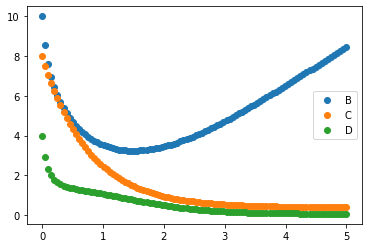

In [84]:
# Plot of the ground truth model
fittedTS = ModelFitter.runSimulation(roadrunner=NEW_MODEL, numPoint=NEW_NUM_POINT, endTime=NEW_END_TIME,
                                     returnDataFrame=False)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=0.0)
_ = plotData(synthesizer.calculate())

We are going to estimate the parameters ``k1``, ``k2``, ``k3``, and the constant value of ``A``.

In [85]:
NEW_PARAMETERS_TO_FIT = ["k1", "k2", "k3", "A"]

## Generate randomized observations

**Question**
1. Generate data with 100 points over 30 s and a stardard deviation of 0.4.

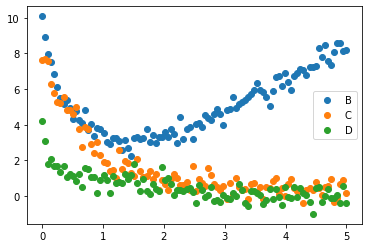

In [86]:
# Solution

fittedTS = ModelFitter.runSimulation(roadrunner=NEW_MODEL, numPoint=NEW_NUM_POINT, endTime=NEW_END_TIME,
                                     returnDataFrame=False)
synthesizer = ObservationSynthesizerRandomErrors(fittedTS=fittedTS, std=NEW_NOISE_STD)
NEW_OBS_TS = synthesizer.calculate()
_ = plotData(NEW_OBS_TS)

**Questions**
1. For what part of these data will it be difficult to estimate the dynamics and therefore the kinetics constants?

## Construct a good fit of the model
**Question**
1. Find a good fit for the model.
1. How good are the estimates relative to ground truth? If there are bad estimates, explain why.
1. Plot the model using the estimated values.

In [88]:
# Solution
NEW_FITTER = ModelFitter(NEW_MODEL, NEW_OBS_TS, parametersToFit=NEW_PARAMETERS_TO_FIT)
NEW_FITTER.fitModel()
NEW_FITTED_TS = NEW_FITTER.fittedTS
NEW_PARAMETER_ESTIMATES = NEW_FITTER.params
print(NEW_FITTER.reportFit())

[[Variables]]
    k1:  9.997313923005546
    k2:  1.8575882419294727
    k3:  1.3186808124924454
    A:  0.24706730220260098
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 300
    # variables        = 4
    chi-square         = 45.0316674
    reduced chi-square = 0.15213401
    Akaike info crit   = -560.924954
    Bayesian info crit = -546.109824
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, A)  = -1.000
    C(k1, k2) =  1.000
    C(k2, A)  = -1.000


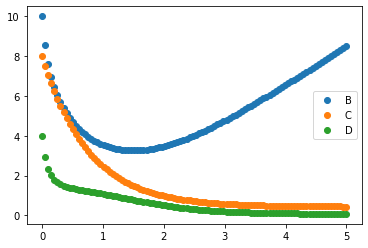

In [26]:
fittedTS = ModelFitter.runSimulation(roadrunner=NEW_MODEL, numPoint=NEW_NUM_POINT, endTime=NEW_END_TIME,
                                     returnDataFrame=False, parameters=NEW_PARAMETER_ESTIMATES)
_ = plotData(fittedTS)

## Estimate the residuals

## Construct bootstrap estimates

# Bootstrapping With SBstoat

In [83]:
NEW_FITTER = ModelFitter(NEW_MODEL, NEW_OBS_TS, parametersToFit=NEW_PARAMETERS_TO_FIT)
NEW_FITTER.fitModel()
NEW_FITTER.bootstrap(numIteration=500, reportInterval=100)
print(NEW_FITTER.reportBootstrap())




6223.519551: ***Running bootstrap for 500 successful iterations with 2 processes.***

6230.113761:     (Bootstrap completed 100 total iterations with 100 successes.)

6230.934870:     (Process 1: Fit has high chisq: 2214.00 on iteration 56.)

6233.123722:     (Process 0: Fit has high chisq: 4529.88 on iteration 72.)

6236.695627:     (Bootstrap completed 200 total iterations with 198 successes.)

6238.488367:     (Process 0: Fit has high chisq: 5029.01 on iteration 112.)

6241.583924:     (Process 0: Fit has high chisq: 1013.41 on iteration 136.)

6243.482206:     (Bootstrap completed 300 total iterations with 294 successes.)

6247.016428:     (Process 1: Fit has high chisq: 3781.53 on iteration 175.)

6247.203895:     (Process 1: Fit has high chisq: 3314.53 on iteration 176.)

6248.319257:     (Process 1: Fit has high chisq: 4775.11 on iteration 184.)

6250.095834:     (Bootstrap completed 400 total iterations with 394 successes.)

6250.402648:     (Process 0: Fit has high chisq: 5